# Código Learning Vector Quantization

## Imports

In [1]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import numpy.linalg as LA
import random

## Funções de Suporte

In [2]:
def sample_prototypes(dataset, n_prototypes = 2):
    '''Choose a number of samples from the dataset to use as prototypes. Will keep at least one sample of every class.'''
    classes = {x[-1]: [a for a in dataset if a[-1] == x[-1]] for x in dataset}
        
    if (n_prototypes < len(classes)):
        print("There aren't prototypes enough for all classes")
    elif (n_prototypes > len(dataset)):
        print("There aren't samples enough for this amount of prototypes")
    else:
        prototypes = [random.choice(classes[x]) for x in classes]
        if (n_prototypes > len(classes)):
            still_not_chosen = [data for data in dataset if np.not_equal(prototypes, data).any(1).all()]
            prototypes.extend(random.sample(still_not_chosen, n_prototypes - len(classes)))
        return prototypes

sample_prototypes(np.array([[1,0,0], [1,1,1], [2,0,2], [2,1,0]]), 4)

[array([2, 1, 0]), array([1, 1, 1]), array([2, 0, 2]), array([1, 0, 0])]

In [3]:
def calculate_test_results(real, predicted):
    matched = [a == b for (a, b) in zip(real, predicted)]
    recalls = {i: list(zip(real, matched)).count((i, True)) / real.count(i) for i in real}
    return {
        "precision": matched.count(True) / len(real),
        "recalls": recalls
    }

## Adaptador do KNN

In [4]:
class KNN_adapter:
    '''An adapter class to use a basic KNN calling the same functions of the LVQ implementations.'''
    def __init__(self, k = 1):
        self.knn = KNeighborsClassifier(n_neighbors = k)
    
    def train(self, training):
        samples = [sample[0:-1] for sample in training]
        labels = [sample[-1] for sample in training]
        self.knn.fit(samples, labels)
    
    def predict(self, sample):
        return self.knn.predict(sample)
    
    def test(self, testing):
        samples = [sample[0:-1] for sample in testing]
        labels = [sample[-1] for sample in testing]
        predicted_labels = self.predict(samples)
        result = calculate_test_results(labels, predicted_labels)
        return result
    
    def get_prototypes(self):
        return None

## Código base das classes do LVQ

In [5]:
class LVQ:
    def __init__(self, k = 1, n_prototypes = 2, alpha_0 = 0.8):
        self.knn = KNeighborsClassifier(n_neighbors = k)
        self.n_prototypes = n_prototypes
        self.alpha_0 = alpha_0
    
    def predict(self, sample):
        return self.knn.predict(sample)
    
    def test(self, testing):
        samples = [sample[0:-1] for sample in testing]
        labels = [sample[-1] for sample in testing]
        predicted_labels = self.predict(samples)
        result = calculate_test_results(labels, predicted_labels)
        return result
    
    def get_prototypes(self):
        return {'samples': self.samples, 'labels': self.labels}

## Código do LVQ1

In [6]:
class LVQ1(LVQ):
    def adjust_prototype(self, prototype_index, alpha, sample):
        prototype = self.samples[prototype_index]
        if (self.labels[prototype_index] == sample[-1]):
            self.samples[prototype_index] = prototype + (sample[0:-1] - prototype) * alpha
        else:
            self.samples[prototype_index] = prototype - (sample[0:-1] - prototype) * alpha
    
    def train(self, training):
        prototypes = sample_prototypes(training, self.n_prototypes)
        self.samples = [sample[0:-1] for sample in prototypes]
        self.labels = [sample[-1] for sample in prototypes]
        
        alpha_t = self.alpha_0
        for sample in training:
            self.knn.fit(self.samples, self.labels)
            closest_index = self.knn.kneighbors([sample[0:-1]], n_neighbors = 1, return_distance = False)[0][0]
            self.adjust_prototype(closest_index, alpha_t, sample)
            alpha_t *= self.alpha_0
        
        self.knn.fit(self.samples, self.labels)

In [7]:
lvq1 = LVQ1(n_prototypes=3)
lvq1.train(np.array([[1,0,0], [1,1,1], [2,0,2], [2,1,0]]))
lvq1.test([[0, 1, 1], [1, 0.2, 0]])
#lvq1.get_prototypes()

{'precision': 0.5, 'recalls': {1: 1.0, 0: 0.0}}

## Código do LVQ2.1

In [8]:
class LVQ2(LVQ):
    def __init__(self, k = 1, n_prototypes = 2, alpha_0 = 0.8, w = 0.5):
        LVQ.__init__(self, k, n_prototypes, alpha_0)
        self.s = (1 - w) / (1 + w)
    
    def window_rule(self, sample, prototypes):
        distances = [LA.norm(prototype - sample[0:-1]) for prototype in prototypes]
        if 0 not in distances:
            min_dist = min(distances[0] / distances[1], distances[1] / distances[0])
            return min_dist > self.s
        return False
    
    def adjust_prototype(self, closest_indexes, alpha, sample):
        prototypes = [self.samples[index] for index in closest_indexes]
        if (self.window_rule(sample, prototypes)):
            if sample[-1] == self.labels[closest_indexes[0]] and sample[-1] != self.labels[closest_indexes[1]]:
                self.samples[closest_indexes[0]] = prototypes[0] + (sample[0:-1] - prototypes[0]) * alpha
                self.samples[closest_indexes[1]] = prototypes[1] - (sample[0:-1] - prototypes[1]) * alpha
            elif sample[-1] != self.labels[closest_indexes[0]] and sample[-1] == self.labels[closest_indexes[1]]:
                self.samples[closest_indexes[0]] = prototypes[0] - (sample[0:-1] - prototypes[0]) * alpha
                self.samples[closest_indexes[1]] = prototypes[1] + (sample[0:-1] - prototypes[1]) * alpha

    def train(self, training, prototypes = None):
        if prototypes == None:
            prototypes = sample_prototypes(training, self.n_prototypes)
            self.samples = [sample[0:-1] for sample in prototypes]
            self.labels = [sample[-1] for sample in prototypes]
        else:
            self.samples = prototypes['samples']
            self.labels = prototypes['labels']
        
        alpha_t = self.alpha_0
        for sample in training:
            self.knn.fit(self.samples, self.labels)
            closest_indexes = self.knn.kneighbors([sample[0:-1]], n_neighbors = 2, return_distance = False)[0]
            self.adjust_prototype(closest_indexes, alpha_t, sample)
            alpha_t *= self.alpha_0
        
        self.knn.fit(self.samples, self.labels)

In [9]:
lvq2 = LVQ2(n_prototypes=3)
lvq2.train(np.array([[1,0,0], [1,1,1], [2,0,2], [2,1,0]]))
#lvq2.test([[0, 1, 1], [1, 0.2, 0]])
lvq2.get_prototypes()

{'samples': [array([1, 0]), array([1, 1]), array([2, 0])], 'labels': [0, 1, 2]}

## Código do LVQ3

In [10]:
class LVQ3(LVQ2):
    def __init__(self, k = 1, n_prototypes = 2, alpha_0 = 0.8, w = 0.5, e = 0.5):
        LVQ2.__init__(self, k, n_prototypes, alpha_0, w)
        self.e = e
    
    def adjust_prototype(self, closest_indexes, alpha, sample):
        prototypes = [self.samples[index] for index in closest_indexes]
        if (self.window_rule(sample, prototypes)):
            if sample[-1] == self.labels[closest_indexes[0]] and sample[-1] != self.labels[closest_indexes[1]]:
                self.samples[closest_indexes[0]] = prototypes[0] + (sample[0:-1] - prototypes[0]) * alpha
                self.samples[closest_indexes[1]] = prototypes[1] - (sample[0:-1] - prototypes[1]) * alpha
            elif sample[-1] != self.labels[closest_indexes[0]] and sample[-1] == self.labels[closest_indexes[1]]:
                self.samples[closest_indexes[0]] = prototypes[0] - (sample[0:-1] - prototypes[0]) * alpha
                self.samples[closest_indexes[1]] = prototypes[1] + (sample[0:-1] - prototypes[1]) * alpha
            elif sample[-1] == self.labels[closest_indexes[0]]:
                self.samples[closest_indexes[0]] = prototypes[0] + (sample[0:-1] - prototypes[0]) * alpha * self.e
                self.samples[closest_indexes[1]] = prototypes[1] + (sample[0:-1] - prototypes[1]) * alpha * self.e

In [11]:
lvq3 = LVQ3(n_prototypes=3)
lvq3.train(np.array([[1,0,0], [1,1,1], [2,0,2], [2,1,0]]))
#lvq3.test([[0, 1, 1], [1, 0.2, 0]])
lvq3.get_prototypes()

{'samples': [array([1, 0]), array([1, 1]), array([2, 0])], 'labels': [0, 1, 2]}

# Avaliações

## Imports

In [12]:
%matplotlib inline

from scipy.io import arff
import pandas as pd
from time import process_time

import matplotlib
import matplotlib.pyplot as plt
from statistics import mean

## Funções para o experimento

In [13]:
def normalize(raw):
    '''Normalizes an dataset so all of its attributes have the same weight.'''
    attribute_mins = np.min(raw, axis=0)
    attribute_maxs = np.max(raw, axis=0)
    return (raw - attribute_mins) / attribute_maxs

In [14]:
def k_fold(sep_samples, k = 5):
    '''Splits the samples in k groups with similar amounts of samples and distributions of every class.'''
    folds = [[] for _ in range(k)]
    for i in sep_samples:
        split_class = np.array_split(sep_samples[i], k)
        [a.extend(b) for (a, b) in zip(folds, split_class)]
    return folds

In [15]:
def cross_validation(machine, folds):
    '''Evaluates an algorithm through cross validation.'''
    knn_ks = [1, 3]

    precisions = {k: [] for k in knn_ks}
    recalls = {k: [] for k in knn_ks}
    train_times = []
    test_times = {k: [] for k in knn_ks}
    prototypes = []
    
    if hasattr(machine, 'n_prototypes'):
        print("Prototypes: " + str(machine.n_prototypes))
    
    for i in range(len(folds)):
        print("Testing on fold " + str(i))
        train = [s for j, fold in enumerate(folds) if i != j for s in fold]
        test = folds[i]

        train_times.append(process_time())
        machine.train(train)
        train_times[-1] = process_time() - train_times[-1]

        for k in knn_ks:
            test_times[k].append(process_time())
            machine.knn.n_neighbors = k
            test_results = machine.test(test)
            test_times[k][-1] = process_time() - test_times[k][-1]

            precisions[k].append(test_results['precision'])
            recalls[k].append(test_results['recalls'])
            
        prototypes.append(machine.get_prototypes())
    return {
        'precisions': precisions,
        'recalls': recalls,
        'train_times': train_times,
        'test_times': test_times,
        'prototypes': prototypes
    }

In [35]:
def cross_validation_lvq23(machine, folds, lvq1_prototypes, n_prototypes):
    '''Evaluates an algorithm through cross validation.'''
    knn_ks = [1, 3]

    precisions = {k: [] for k in knn_ks}
    recalls = {k: [] for k in knn_ks}
    train_times = []
    test_times = {k: [] for k in knn_ks}
    prototypes = []
    
    print("Prototypes: " + str(n_prototypes))
    
    for i in range(len(folds)):
        print("Testing on fold " + str(i))
        train = [s for j, fold in enumerate(folds) if i != j for s in fold]
        test = folds[i]

        train_times.append(process_time())
        machine.train(train, lvq1_prototypes[i])
        train_times[-1] = process_time() - train_times[-1]

        for k in knn_ks:
            test_times[k].append(process_time())
            machine.knn.n_neighbors = k
            test_results = machine.test(test)
            test_times[k][-1] = process_time() - test_times[k][-1]

            precisions[k].append(test_results['precision'])
            recalls[k].append(test_results['recalls'])
        
        prototypes.append(machine.get_prototypes())
    return {
        'precisions': precisions,
        'recalls': recalls,
        'train_times': train_times,
        'test_times': test_times,
        'prototypes': prototypes
    }

In [25]:
prototypes_amounts = [3, 5, 10, 15, 20, 25, 30, 35, 40]
def experiment(machine, folds, amounts = prototypes_amounts):
    def set_machine(machine, amount):
        machine.n_prototypes = amount
        return machine
    
    random.seed(42)
    
    return {amount: cross_validation(set_machine(machine, amount), folds) for amount in amounts}

In [36]:
def experiment_lvq23(machine, folds, prototypes):
    random.seed(42)
    
    return {amount: cross_validation_lvq23(machine, folds, prototypes[amount], amount) for amount in prototypes}

In [27]:
# The machines
knn = KNN_adapter()
lvq1 = LVQ1()
lvq2 = LVQ2()
lvq3 = LVQ2()

## Base de Dados 1 - KC1

### Preparação

In [28]:
data = arff.loadarff('Datasets/kc1.arff')
dataFrame = pd.DataFrame(data[0])
dataFrame.defects = [1 if i == b'true' else 0 for i in dataFrame.defects]
rawData1 = dataFrame.values
rawData1

array([[ 1.1,  1.4,  1.4, ...,  1.2,  1.4,  0. ],
       [ 1. ,  1. ,  1. , ...,  1. ,  1. ,  1. ],
       [83. , 11. ,  1. , ..., 64. , 21. ,  1. ],
       ...,
       [ 2. ,  1. ,  1. , ...,  1. ,  1. ,  0. ],
       [13. ,  1. ,  1. , ...,  8. ,  1. ,  0. ],
       [11. ,  2. ,  1. , ...,  9. ,  3. ,  0. ]])

In [29]:
# Normalizing the dataset
normalizedData1 = normalize(rawData1)
normalizedData1

# Separating samples by class
classes1 = {i[-1]: normalizedData1[np.where(rawData1[:,-1] == i[-1])] for i in normalizedData1}
classes1

# Separating the folds
folds1 = k_fold(classes1)
folds1

[[array([3.47222222e-04, 8.88888889e-03, 1.53846154e-02, 8.88888889e-03,
         1.17540687e-03, 1.64165873e-04, 6.50000000e-01, 2.41860465e-02,
         6.73365793e-03, 4.00241980e-06, 4.92424242e-01, 7.20435542e-05,
         7.63358779e-03, 4.54545455e-02, 3.44827586e-02, 1.66666667e-01,
         3.24324324e-02, 1.00000000e-02, 1.76991150e-03, 2.80373832e-03,
         4.49438202e-03, 0.00000000e+00]),
  array([0.01388889, 0.        , 0.        , 0.        , 0.00994575,
         0.00389957, 0.19      , 0.04967442, 0.05998135, 0.00025354,
         0.00378788, 0.00025326, 0.01145038, 0.        , 0.        ,
         0.        , 0.10810811, 0.025     , 0.01032448, 0.00934579,
         0.        , 0.        ]),
  array([0.00694444, 0.        , 0.        , 0.        , 0.00090416,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.00381679, 0.        , 0.        ,
         0.        , 0.02702703, 0.        , 0.00147493, 0.        ,
     

### Execução do KNN básico

In [30]:
knn_results1 = cross_validation(knn, folds1)
knn_results1

Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4


{'precisions': {1: [0.7825059101654847,
   0.7890995260663507,
   0.7535545023696683,
   0.8194774346793349,
   0.7553444180522565],
  3: [0.817966903073286,
   0.8246445497630331,
   0.7819905213270142,
   0.8574821852731591,
   0.8432304038004751]},
 'recalls': {1: [{0.0: 0.8543417366946778, 1.0: 0.3939393939393939},
   {0.0: 0.865546218487395, 1.0: 0.36923076923076925},
   {0.0: 0.8235294117647058, 1.0: 0.36923076923076925},
   {0.0: 0.9185393258426966, 1.0: 0.27692307692307694},
   {0.0: 0.8286516853932584, 1.0: 0.35384615384615387}],
  3: [{0.0: 0.9103641456582633, 1.0: 0.3181818181818182},
   {0.0: 0.9187675070028011, 1.0: 0.3076923076923077},
   {0.0: 0.8851540616246498, 1.0: 0.2153846153846154},
   {0.0: 0.9719101123595506, 1.0: 0.23076923076923078},
   {0.0: 0.9410112359550562, 1.0: 0.3076923076923077}]},
 'train_times': [0.0, 0.0, 0.015625, 0.0, 0.0],
 'test_times': {1: [0.21875, 0.234375, 0.203125, 0.1875, 0.234375],
  3: [0.234375, 0.1875, 0.25, 0.203125, 0.21875]},
 'proto

### Execução do LVQ1

In [31]:
lvq1_results1 = experiment(lvq1, folds1)
lvq1_results1

Prototypes: 3
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 5
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 10
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 15
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 20
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 25
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 30
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 35
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 40
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4


{3: {'precisions': {1: [0.46099290780141844,
    0.7156398104265402,
    0.7156398104265402,
    0.828978622327791,
    0.8978622327790974],
   3: [0.8439716312056738,
    0.8459715639810427,
    0.8459715639810427,
    0.1543942992874109,
    0.8456057007125891]},
  'recalls': {1: [{0.0: 0.36694677871148457, 1.0: 0.9696969696969697},
    {0.0: 0.711484593837535, 1.0: 0.7384615384615385},
    {0.0: 0.7591036414565826, 1.0: 0.47692307692307695},
    {0.0: 0.898876404494382, 1.0: 0.4461538461538462},
    {0.0: 0.9662921348314607, 1.0: 0.5230769230769231}],
   3: [{0.0: 1.0, 1.0: 0.0},
    {0.0: 1.0, 1.0: 0.0},
    {0.0: 1.0, 1.0: 0.0},
    {0.0: 0.0, 1.0: 1.0},
    {0.0: 1.0, 1.0: 0.0}]},
  'train_times': [2.03125, 1.96875, 2.046875, 2.015625, 1.90625],
  'test_times': {1: [0.1875, 0.25, 0.15625, 0.171875, 0.171875],
   3: [0.171875, 0.21875, 0.171875, 0.1875, 0.171875]},
  'prototypes': [{'samples': [array([ 2.78982301e-09,  4.16884029e-30,  0.00000000e+00,  4.16884029e-30,
            

In [32]:
lvq1_prototypes1 = {amount: lvq1_results1[amount]['prototypes'] for amount in lvq1_results1}
lvq1_prototypes1

{3: [{'samples': [array([ 2.78982301e-09,  4.16884029e-30,  0.00000000e+00,  4.16884029e-30,
            3.63231931e-10,  1.98018738e-22,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            1.53333784e-09, -4.93926738e-38,  1.10579077e-20,  0.00000000e+00,
            1.08576896e-08,  6.18326004e-21,  5.92528784e-10,  2.31149908e-21,
            4.21568119e-30]),
    array([ 3.35619236e-02,  1.46618910e-02, -3.95049200e-05,  1.47267890e-02,
            1.14544789e-02,  4.40819490e-03,  7.43614248e-02,  1.15558767e-01,
            3.76212163e-02, -3.73825894e-05,  5.87597815e-03, -3.76858944e-05,
            2.94353618e-02, -1.38871057e-07,  1.97249915e-02, -4.23101320e-05,
            1.94076773e-01,  2.79249039e-02,  9.88916415e-03,  1.39341130e-02,
            1.48266322e-02]),
    array([1.78534587e-03, 4.18892861e-36, 0.00000000e+00, 0.00000000e+00,
           3.70832673e-03, 1.06724393e-03, 3.34206310e-01, 2.

### Execução do LVQ2.1

In [37]:
lvq2_results1 = experiment_lvq23(lvq2, folds1, lvq1_prototypes1.copy())
lvq2_results1

Prototypes: 3
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 5
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 10
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 15
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 20
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 25
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 30
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 35
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 40
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4


{3: {'precisions': {1: [0.41134751773049644,
    0.8554502369668247,
    0.7274881516587678,
    0.8574821852731591,
    0.8978622327790974],
   3: [0.8439716312056738,
    0.8459715639810427,
    0.8459715639810427,
    0.1543942992874109,
    0.8456057007125891]},
  'recalls': {1: [{0.0: 0.3081232492997199, 1.0: 0.9696969696969697},
    {0.0: 0.9495798319327731, 1.0: 0.3384615384615385},
    {0.0: 0.773109243697479, 1.0: 0.47692307692307695},
    {0.0: 0.9719101123595506, 1.0: 0.23076923076923078},
    {0.0: 0.9662921348314607, 1.0: 0.5230769230769231}],
   3: [{0.0: 1.0, 1.0: 0.0},
    {0.0: 1.0, 1.0: 0.0},
    {0.0: 1.0, 1.0: 0.0},
    {0.0: 0.0, 1.0: 1.0},
    {0.0: 1.0, 1.0: 0.0}]},
  'train_times': [1.015625, 0.9375, 0.96875, 1.0, 0.890625],
  'test_times': {1: [0.1875, 0.203125, 0.21875, 0.171875, 0.171875],
   3: [0.171875, 0.21875, 0.21875, 0.171875, 0.171875]},
  'prototypes': [{'samples': [array([1.29639395e-02, 1.16621595e-02, 3.94037770e-05, 1.15974724e-02,
            1.

### Execução do LVQ3

In [38]:
lvq3_results1 = experiment_lvq23(lvq3, folds1, lvq1_prototypes1.copy())
lvq3_results1

Prototypes: 3
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 5
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 10
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 15
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 20
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 25
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 30
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 35
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Prototypes: 40
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4


{3: {'precisions': {1: [0.7375886524822695,
    0.8483412322274881,
    0.7322274881516587,
    0.8598574821852731,
    0.8978622327790974],
   3: [0.8439716312056738,
    0.8459715639810427,
    0.8459715639810427,
    0.1543942992874109,
    0.8456057007125891]},
  'recalls': {1: [{0.0: 0.8711484593837535, 1.0: 0.015151515151515152},
    {0.0: 0.9663865546218487, 1.0: 0.2},
    {0.0: 0.7927170868347339, 1.0: 0.4},
    {0.0: 0.9747191011235955, 1.0: 0.23076923076923078},
    {0.0: 0.9662921348314607, 1.0: 0.5230769230769231}],
   3: [{0.0: 1.0, 1.0: 0.0},
    {0.0: 1.0, 1.0: 0.0},
    {0.0: 1.0, 1.0: 0.0},
    {0.0: 0.0, 1.0: 1.0},
    {0.0: 1.0, 1.0: 0.0}]},
  'train_times': [1.015625, 0.90625, 0.875, 0.890625, 0.90625],
  'test_times': {1: [0.171875, 0.171875, 0.171875, 0.171875, 0.171875],
   3: [0.171875, 0.171875, 0.171875, 0.171875, 0.171875]},
  'prototypes': [{'samples': [array([2.28672546e-02, 2.05710306e-02, 6.95048204e-05, 2.04569281e-02,
            2.07332226e-02, 1.29483

### Gráficos

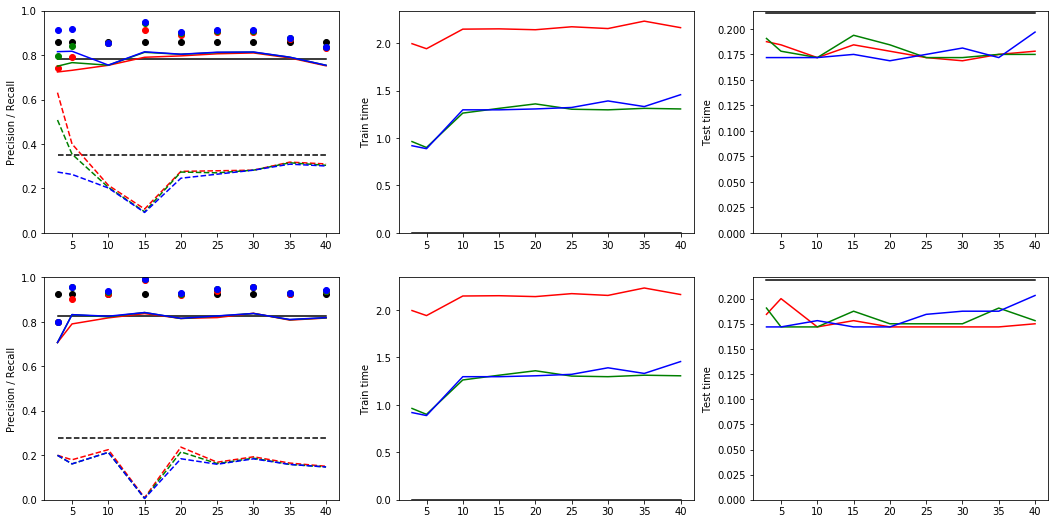

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

axes[0,0].plot(prototypes_amounts, [mean(knn_results1['precisions'][1]) for _ in prototypes_amounts], 'k')
axes[0,0].plot(prototypes_amounts, [mean([a[0] for a in knn_results1['recalls'][1]]) for _ in prototypes_amounts], 'ko')
axes[0,0].plot(prototypes_amounts, [mean([a[1] for a in knn_results1['recalls'][1]]) for _ in prototypes_amounts], 'k--')

axes[0,0].plot(prototypes_amounts, [mean(lvq1_results1[i]['precisions'][1]) for i in lvq1_results1], 'r')
axes[0,0].plot(prototypes_amounts, [mean([a[0] for a in lvq1_results1[i]['recalls'][1]]) for i in lvq1_results1], 'ro')
axes[0,0].plot(prototypes_amounts, [mean([a[1] for a in lvq1_results1[i]['recalls'][1]]) for i in lvq1_results1], 'r--')

axes[0,0].plot(prototypes_amounts, [mean(lvq2_results1[i]['precisions'][1]) for i in lvq2_results1], 'g')
axes[0,0].plot(prototypes_amounts, [mean([a[0] for a in lvq2_results1[i]['recalls'][1]]) for i in lvq2_results1], 'go')
axes[0,0].plot(prototypes_amounts, [mean([a[1] for a in lvq2_results1[i]['recalls'][1]]) for i in lvq2_results1], 'g--')

axes[0,0].plot(prototypes_amounts, [mean(lvq3_results1[i]['precisions'][1]) for i in lvq3_results1], 'b')
axes[0,0].plot(prototypes_amounts, [mean([a[0] for a in lvq3_results1[i]['recalls'][1]]) for i in lvq3_results1], 'bo')
axes[0,0].plot(prototypes_amounts, [mean([a[1] for a in lvq3_results1[i]['recalls'][1]]) for i in lvq3_results1], 'b--')


axes[1,0].plot(prototypes_amounts, [mean(knn_results1['precisions'][3]) for _ in prototypes_amounts], 'k')
axes[1,0].plot(prototypes_amounts, [mean([a[0] for a in knn_results1['recalls'][3]]) for _ in prototypes_amounts], 'ko')
axes[1,0].plot(prototypes_amounts, [mean([a[1] for a in knn_results1['recalls'][3]]) for _ in prototypes_amounts], 'k--')

axes[1,0].plot(prototypes_amounts, [mean(lvq1_results1[i]['precisions'][3]) for i in lvq1_results1], 'r')
axes[1,0].plot(prototypes_amounts, [mean([a[0] for a in lvq1_results1[i]['recalls'][3]]) for i in lvq1_results1], 'ro')
axes[1,0].plot(prototypes_amounts, [mean([a[1] for a in lvq1_results1[i]['recalls'][3]]) for i in lvq1_results1], 'r--')

axes[1,0].plot(prototypes_amounts, [mean(lvq2_results1[i]['precisions'][3]) for i in lvq2_results1], 'g')
axes[1,0].plot(prototypes_amounts, [mean([a[0] for a in lvq2_results1[i]['recalls'][3]]) for i in lvq2_results1], 'go')
axes[1,0].plot(prototypes_amounts, [mean([a[1] for a in lvq2_results1[i]['recalls'][3]]) for i in lvq2_results1], 'g--')

axes[1,0].plot(prototypes_amounts, [mean(lvq3_results1[i]['precisions'][3]) for i in lvq3_results1], 'b')
axes[1,0].plot(prototypes_amounts, [mean([a[0] for a in lvq3_results1[i]['recalls'][3]]) for i in lvq3_results1], 'bo')
axes[1,0].plot(prototypes_amounts, [mean([a[1] for a in lvq3_results1[i]['recalls'][3]]) for i in lvq3_results1], 'b--')


axes[0,1].plot(prototypes_amounts, [mean(knn_results1['train_times']) for _ in prototypes_amounts], 'k')
axes[0,1].plot(prototypes_amounts, [mean(lvq1_results1[i]['train_times']) for i in lvq1_results1], 'r')
axes[0,1].plot(prototypes_amounts, [mean(lvq2_results1[i]['train_times']) for i in lvq2_results1], 'g')
axes[0,1].plot(prototypes_amounts, [mean(lvq3_results1[i]['train_times']) for i in lvq3_results1], 'b')

axes[1,1].plot(prototypes_amounts, [mean(knn_results1['train_times']) for _ in prototypes_amounts], 'k')
axes[1,1].plot(prototypes_amounts, [mean(lvq1_results1[i]['train_times']) for i in lvq1_results1], 'r')
axes[1,1].plot(prototypes_amounts, [mean(lvq2_results1[i]['train_times']) for i in lvq2_results1], 'g')
axes[1,1].plot(prototypes_amounts, [mean(lvq3_results1[i]['train_times']) for i in lvq3_results1], 'b')


axes[0,2].plot(prototypes_amounts, [mean(knn_results1['test_times'][1]) for _ in prototypes_amounts], 'k')
axes[0,2].plot(prototypes_amounts, [mean(lvq1_results1[i]['test_times'][1]) for i in lvq1_results1], 'r')
axes[0,2].plot(prototypes_amounts, [mean(lvq2_results1[i]['test_times'][1]) for i in lvq2_results1], 'g')
axes[0,2].plot(prototypes_amounts, [mean(lvq3_results1[i]['test_times'][1]) for i in lvq3_results1], 'b')

axes[1,2].plot(prototypes_amounts, [mean(knn_results1['test_times'][3]) for _ in prototypes_amounts], 'k')
axes[1,2].plot(prototypes_amounts, [mean(lvq1_results1[i]['test_times'][3]) for i in lvq1_results1], 'r')
axes[1,2].plot(prototypes_amounts, [mean(lvq2_results1[i]['test_times'][3]) for i in lvq2_results1], 'g')
axes[1,2].plot(prototypes_amounts, [mean(lvq3_results1[i]['test_times'][3]) for i in lvq3_results1], 'b')


axes[0,0].set_ylabel('Precision / Recall')
axes[1,0].set_ylabel('Precision / Recall')
axes[0,0].set_ylim(0, 1)
axes[1,0].set_ylim(0, 1)

axes[0,1].set_ylabel('Train time')
axes[1,1].set_ylabel('Train time')
axes[0,1].set_ylim(0)
axes[1,1].set_ylim(0)

axes[0,2].set_ylabel('Test time')
axes[1,2].set_ylabel('Test time')
axes[0,2].set_ylim(0)
axes[1,2].set_ylim(0)

plt.show()

## Base de Dados 2 - JM1

### Preparação

In [ ]:
data = arff.loadarff('Datasets/jm1.arff')
dataFrame = pd.DataFrame(data[0])
dataFrame.defects = [1 if i == b'true' else 0 for i in dataFrame.defects]
rawData2 = dataFrame.values
rawData2

In [ ]:
# Normalizing the dataset
normalizedData2 = normalize(rawData2)
normalizedData2

# Separating samples by class
classes2 = {i[-1]: normalizedData2[np.where(rawData[:,-1] == i[-1])] for i in normalizedData2}
classes2

# Separating the folds
folds2 = k_fold(classes2)
folds2

### Execução do KNN básico

In [ ]:
knn_results2 = cross_validation(knn, folds2)
knn_results2

### Execução do LVQ1

In [ ]:
lvq1_results2 = experiment(lvq1, folds2)
lvq1_results2

In [ ]:
lvq1_prototypes2 = {amount: lvq1_results2[amount]['prototypes'] for amount in lvq1_results2}
lvq1_prototypes2

### Execução do LVQ2.1

In [ ]:
lvq2_results2 = experiment_lvq23(lvq2, folds2, lvq1_prototypes2.copy())
lvq2_results2

### Execução do LVQ3

In [ ]:
lvq3_results2 = experiment_lvq23(lvq3, folds2, lvq1_prototypes2.copy())
lvq3_results2

### Gráficos